In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Step 1 : setup

In [27]:
import configparser
import warnings
from datetime import datetime
from os import path
from typing import Optional, List

from datetime import timedelta
import math
import matplotlib.pyplot as plt

import pandas as pd
from binance.client import Client
from sqlalchemy.orm import Session

from binance_trade_bot.database import Database
from binance_trade_bot.logger import Logger
from binance_trade_bot.models import Trade

# Ignore dateparser warnings regarding pytz
warnings.filterwarnings(
    "ignore",
    message="The localize method is no longer necessary, as this time zone supports the fold attribute",
)

CFG_FL_NAME = "../user.cfg"
USER_CFG_SECTION = "binance_user_config"
DATA_STORAGE_PATH = "history_data/binance/"
COIN_FILE_NAME='supported_coin_list'

config = configparser.ConfigParser()
config.read(CFG_FL_NAME)

api_key = config.get(USER_CFG_SECTION, "api_key")
api_secret = config.get(USER_CFG_SECTION, "api_secret_key")
client = Client(api_key, api_secret)

#### Step 2 : Read first trade date, coin list and download data since first trade day

In [ ]:



logger = Logger("analyze_trades.ipnyb")
db = Database(logger, config)


def get_ticker_price(ticker_symbol: str, start_date: str, end_date: str = None):
    """
    Get ticker price of a specific coin at 1m interval
    Check if data is already downloaded, if NOT downloaded..just append to it
    """
    file_path = DATA_STORAGE_PATH + ticker_symbol + '.pkl'
    binance_date_format = '%d %b %Y %H:%M:%S'
    input_date_format = '%Y-%m-%d %H:%M:%S'

    from_date = datetime.strptime(start_date + ' 00:00:00', input_date_format)
    to_date = datetime.now()
    if end_date is not None:
        end_date = end_date + ' 23:59:00'
        to_date = min(datetime.strptime(end_date, input_date_format), to_date)

    key = f"{ticker_symbol}"
    if path.isfile(file_path):
        d = pd.read_pickle(file_path)
        dates = d['date'].values
        f = datetime.strptime(dates[0], binance_date_format)
        t = datetime.strptime(dates[-1], binance_date_format)

        if f <= from_date and t >= to_date:
            print(f'[{ticker_symbol}] Returning stored {file_path} from {from_date} to {to_date}')
            d['date'] = pd.to_datetime(d['date'])
            return d.loc[
                (d['date'] >= from_date) &
                (d['date'] <= to_date)
                ]

    print(f'[{ticker_symbol}] Downloading from {from_date} to {to_date}')

    coindata = pd.DataFrame(columns=[key])

    prices = []
    dates = []
    for result in client.get_historical_klines(symbol=ticker_symbol,
                                               interval="1m",
                                               start_str=from_date.strftime(binance_date_format),
                                               end_str=to_date.strftime(binance_date_format),
                                               limit=1000):
        date = datetime.utcfromtimestamp(result[0] / 1000).strftime(binance_date_format)
        price = float(result[1])
        dates.append(date)
        prices.append(price)

    coindata[key] = prices
    coindata['date'] = dates

    d = (coindata.reindex(columns=['date', key]))
    d.to_pickle(file_path)
    d['date'] = pd.to_datetime(d['date'])
    return d

def get_first_trade_date() -> Optional[datetime]:
    session: Session
    with db.db_session() as session:
        result: Trade = session.query(Trade).order_by(Trade.datetime.asc()).first()
        date = result.datetime
        session.expunge_all()
    return date

def get_all_coins()->Optional[List[str]]:
    with open(COIN_FILE_NAME) as f:
        contents = f.read().split('\n')
        result = []
        for coin in contents:
            result.append(coin+'USDT')
        return result



first_trading_day = get_first_trade_date().strftime("%Y-%m-%d")
cointickers = get_all_coins()

coindata = get_ticker_price(cointickers[0], first_trading_day , '2022-01-31')

for tick in cointickers[1:]:
    newdata = get_ticker_price(tick, first_trading_day , '2022-01-31')
    coindata = pd.merge(coindata, newdata)

coindata

#ticker = get_ticker_price('BTCUSDT', '2022-01-04', '2022-01-04')

<AxesSubplot:xlabel='date'>

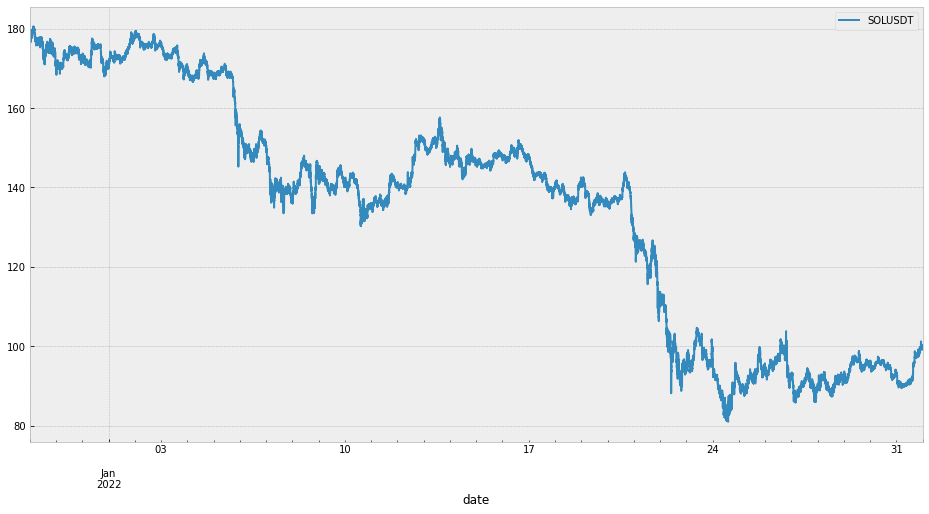

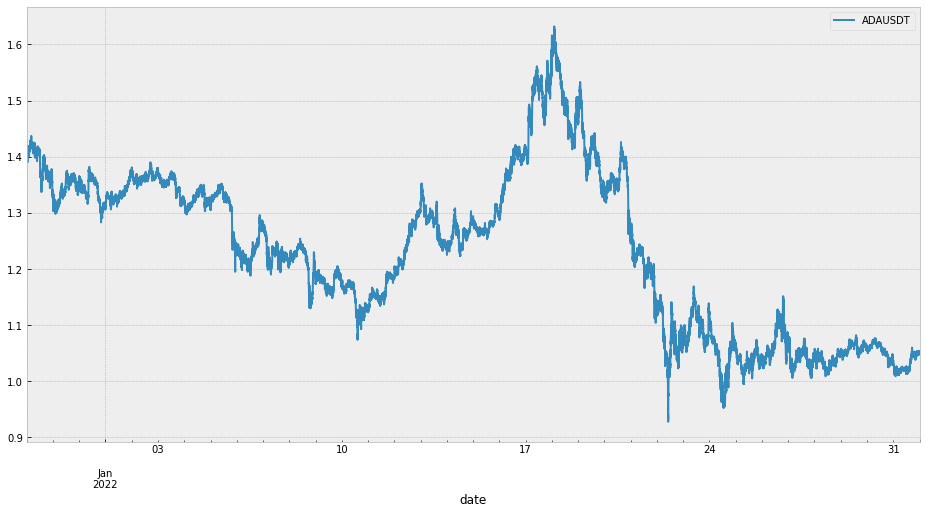

In [112]:
#fig = plt.figure(figsize=(20,8))
coindata.plot('date','SOLUSDT',figsize = (16,8),)

#fig = plt.figure(figsize=(20,8))
coindata.plot('date','ADAUSDT',figsize = (16,8),)

#### Step 3 : Plot prices

C:\Users\skhan\AppData\Local\Temp\ipykernel_510296\3304845040.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coindata_normalized[c] = coindata[c]
C:\Users\skhan\AppData\Local\Temp\ipykernel_510296\3304845040.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coindata_normalized[c] = coindata[c]
C:\Users\skhan\AppData\Local\Temp\ipykernel_510296\3304845040.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

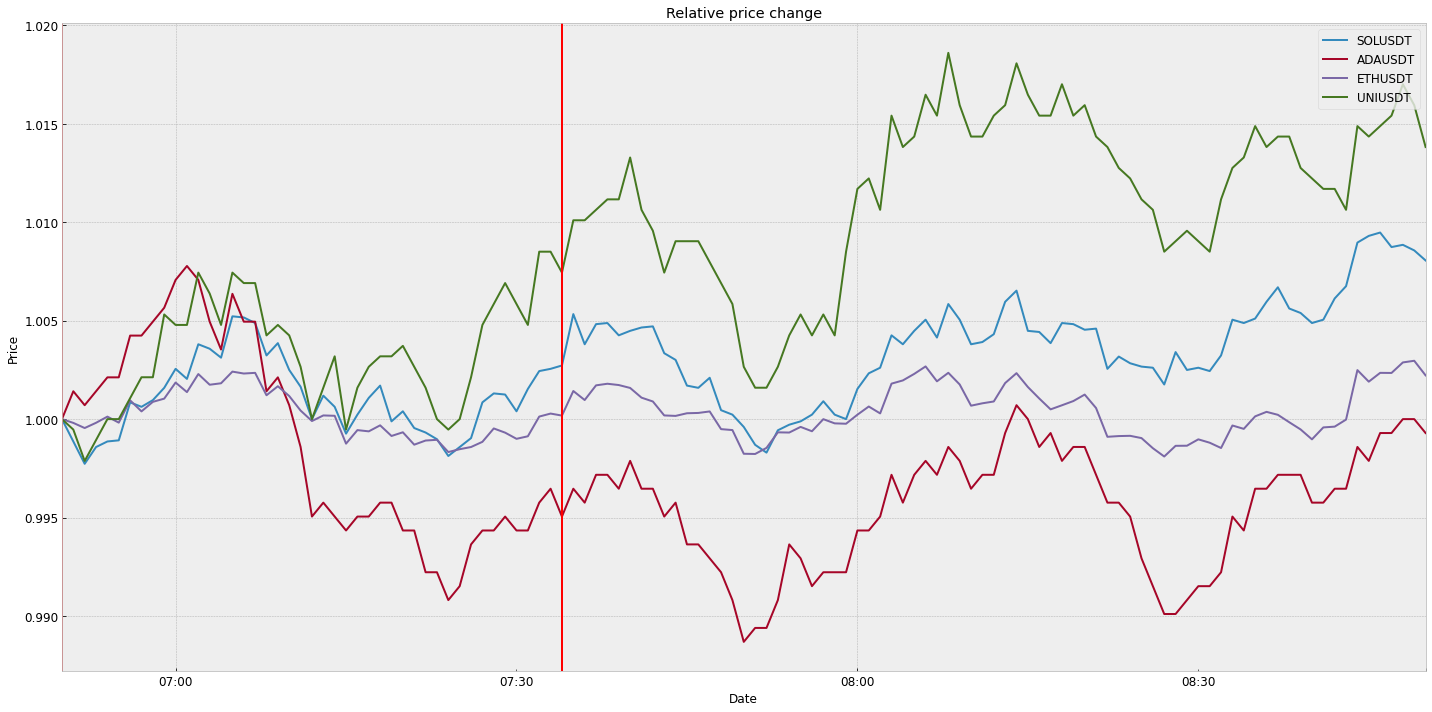

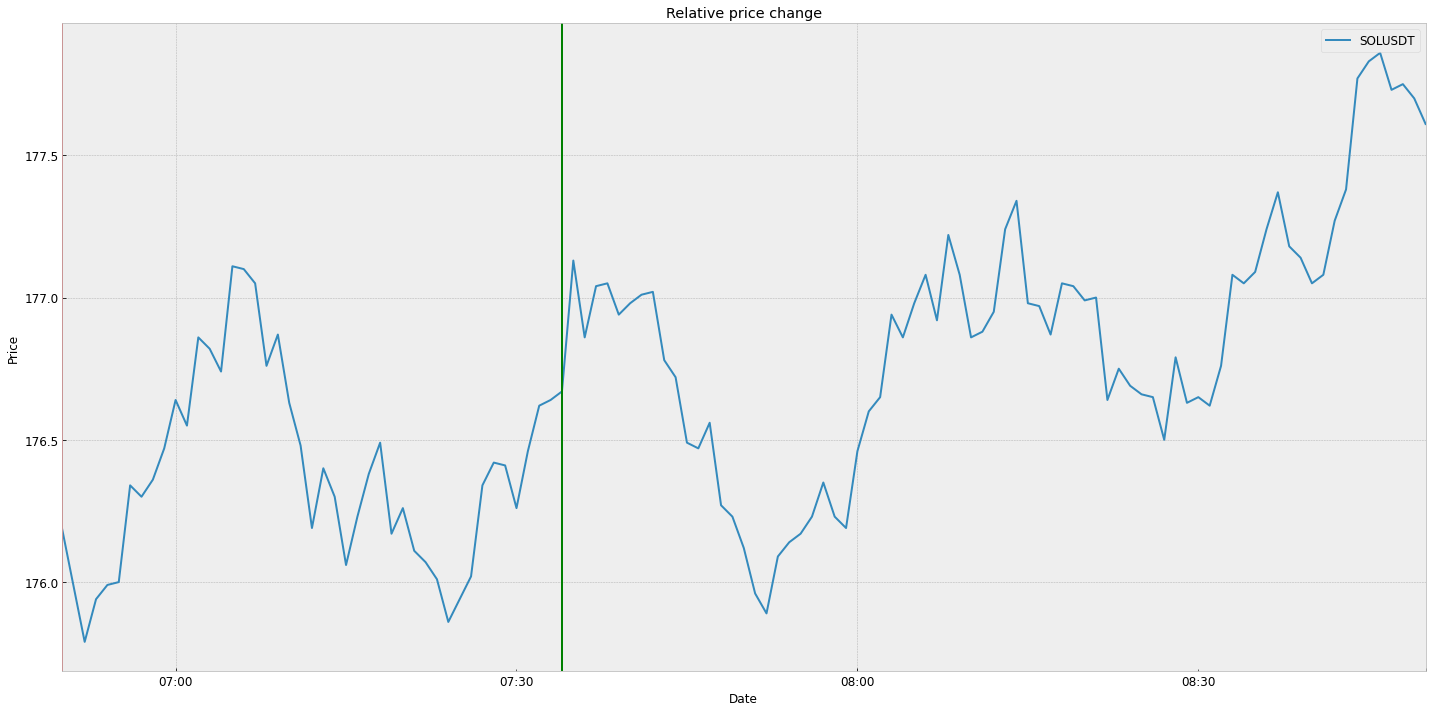

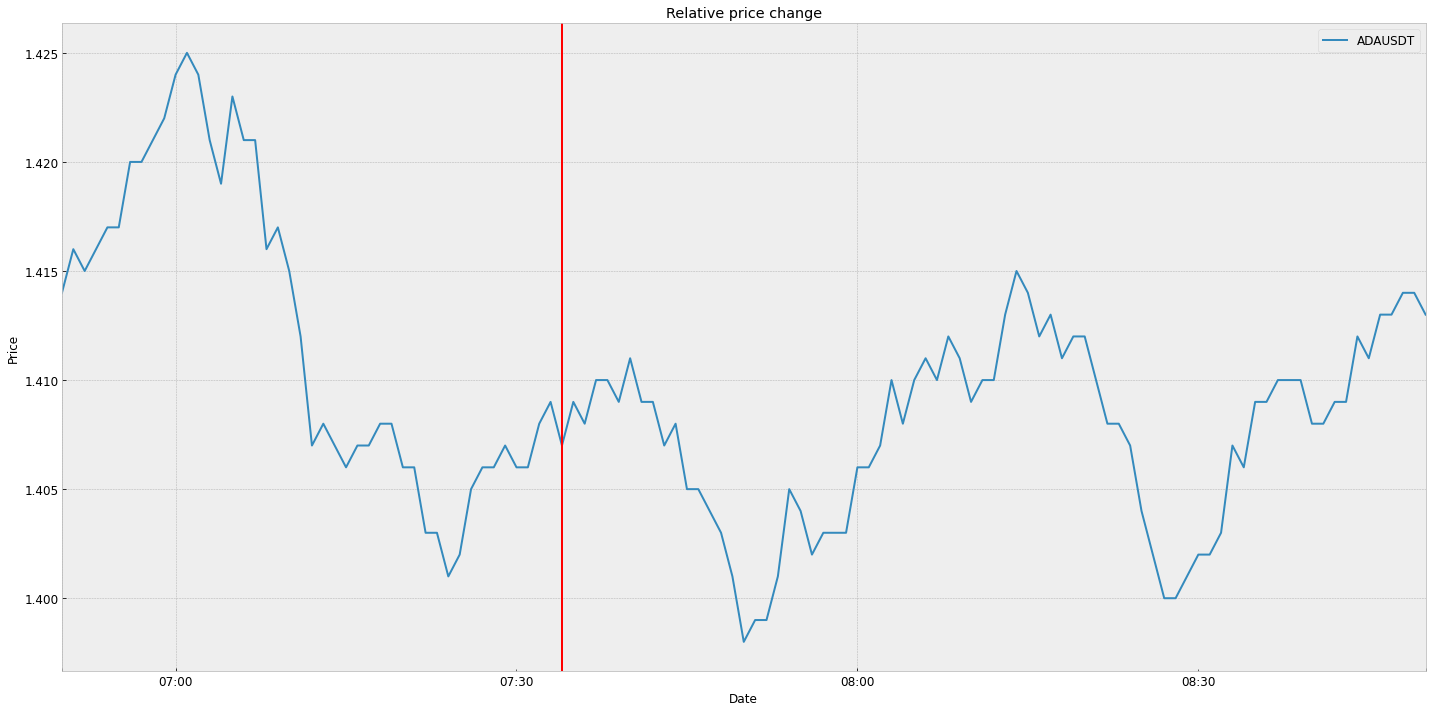

In [129]:
def get_all_trades() -> Optional[Trade]:
    with db.db_session() as session:
        result = session.query(Trade).all()
        session.expunge_all()
    return result


def f_normalize_data(df):
    return df / df.iloc[0, :]


def f_plot_data(df, title="Crypto prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""

    ax = df.plot(title=title, fontsize=12, figsize=(20, 10))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

    #plt.figure(figsize=(150, 80), dpi= 120, facecolor='w', edgecolor='k')
    plt.title('Relative price change')
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.style.use('bmh')
    plt.grid(True)
    return plt


def get_last_trading_date() -> Optional[datetime]:
    session: Session
    with db.db_session() as session:
        result: Trade = session.query(Trade).order_by(Trade.datetime.desc()).first()
        date = result.datetime
        session.expunge_all()
    return date


def ceil_dt(dt, delta):
    return datetime.min + math.ceil((dt - datetime.min) / delta) * delta


def floor_dt(dt, delta):
    return datetime.min + math.floor((dt - datetime.min) / delta) * delta


## Too much data so lets just plot a subset.

trades: List[Trade] = get_all_trades()

coindata_normalized = coindata[['date']]

for t in trades:
    c = t.alt_coin_id + 'USDT'
    if c not in coindata_normalized:
        coindata_normalized[c] = coindata[c]

first_trade = datetime.strptime('2021-12-29 06:50:51.000', '%Y-%m-%d %H:%M:%S.%f')  #get_first_trade_date()
first_trade = floor_dt(first_trade, timedelta(minutes=1))

last_trade = first_trade + timedelta(
    minutes=120)  #datetime.strptime('2021-12-29 07:34:03.353011', '%Y-%m-%d %H:%M:%S') # get_last_trading_date()
last_trade = ceil_dt(last_trade, timedelta(minutes=1))

allowed = ['date', 'SOLUSDT', 'ADAUSDT','ETHUSDT','UNIUSDT']

coindata_normalized = coindata_normalized[
    (coindata_normalized['date'] >= first_trade) &
    (coindata_normalized['date'] <= last_trade)
    ]
coindata_normalized = coindata_normalized.loc[:, coindata_normalized.columns.isin(allowed)]

coindata_filtered = coindata_normalized.copy(deep=True)
# coindata_filtered['date'] = coindata_normalized['date']
# coindata_filtered.set_index('date', inplace=True)

coindata_normalized = f_normalize_data(coindata_normalized.drop('date', axis='columns'))

coindata_normalized['date'] = coindata['date']

#coindata_normalized.insert(loc=0,column='date',value=coindata['date'])

coindata_normalized.set_index('date', inplace=True)


f_plot_data(coindata_normalized)

text_v_locations = [.75, .775, .8, .825, .85, .875, .9]

i = 1
for t in trades:
    if t.datetime <= first_trade or t.datetime >= last_trade:
        continue
    if t.selling == 1:
        text_location = text_v_locations[(len(text_v_locations) - 1) % i]
        plt.axvline(x=t.datetime, color='g')
        #plt.text(t.datetime, text_location, 'Selling ' + t.alt_coin_id, )
    if t.selling == 0:
        text_location = text_v_locations[(len(text_v_locations) - 1) % i]
        plt.axvline(x=t.datetime, color='r', label=t.alt_coin_id)
        #plt.text(t.datetime, text_location, 'Buying ' + t.alt_coin_id, )
        i = i + 1

plt.show()

sol = coindata_filtered[['SOLUSDT','date']]
sol.set_index('date', inplace=True)
plt_sol = f_plot_data(sol)
for t in trades:
    if t.datetime <= first_trade or t.datetime >= last_trade or t.alt_coin_id != 'SOL':
        continue
    if t.selling == 1:
        plt_sol.axvline(x=t.datetime, color='g')
        #plt_sol.text(t.datetime, 176, f'Selling @ {coindata_filtered.loc[t.datetime].SOLUSDT}' )
    if t.selling == 0:
        plt_sol.axvline(x=t.datetime, color='r')
        #plt_sol.text(t.datetime, 176, 'Buying ')
plt_sol.show()


ada = coindata_filtered[['ADAUSDT','date']]
ada.set_index('date', inplace=True)
plt_ada = f_plot_data(ada)
for t in trades:
    if t.datetime <= first_trade or t.datetime >= last_trade or t.alt_coin_id != 'ADA':
        continue
    if t.selling == 1:
        plt_ada.axvline(x=t.datetime, color='g')
        #plt_ada.text(t.datetime, 176, f'Selling @ {coindata_filtered.loc[t.datetime].ADAUSDT}' )
    if t.selling == 0:
        plt_ada.axvline(x=t.datetime, color='r')
        #plt_ada.text(t.datetime, 176, 'Buying ')
plt_ada.show()



### Step 4 : Plot ohlc and trades